# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


### Why We're Here 

This is an image classification project for identifying dog breeds. Identifying dog breeds is useful for finding dogs with preferred characteristics, like
growth size, whether they are suited to indoors or outdoors and the toes and quantity of food they eat. It can also be used for targeted advertising. Food and toys for specific breeds of dogs can be advertised to users with those dogs.

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:


* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [6]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


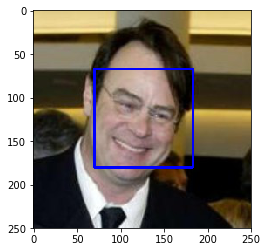

In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [9]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_results = []
dog_results = []

for human_file in tqdm(human_files_short):
    human_results.append(face_detector(human_file))
    
for dog_file in tqdm(dog_files_short):
    dog_results.append(face_detector(dog_file))
    
# human_results = list(map(face_detector, human_files_short))
# dog_results = list(map(face_detector, dog_files_short))

print(f'human_accuracy {np.mean(human_results)}')
print(f'dog_accuracy {np.mean(dog_results)}')


100%|██████████| 100/100 [00:29<00:00,  7.23it/s]

human_accuracy 0.98
dog_accuracy 0.17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [11]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 55401695.68it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

We will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

[PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [12]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path).convert('RGB')
    
    transformations = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    transformed_image = transformations(img)[:3,:,:].unsqueeze(0)
    if use_cuda:
        transformed_image = transformed_image.to('cuda')
    output = VGG16(transformed_image)
    _, preds = torch.max(output, 1)
    predictions = np.squeeze(preds.cpu().numpy()) 
    
    return int(predictions) # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

We will use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    image_net_pred = VGG16_predict(img_path)
    if image_net_pred >= 150 and image_net_pred <= 268:
        return True
    return False

### Assess the Dog Detector

We want to test the performance of our dog detectore function 
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [14]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_results = []
dog_results = []

for human_file in tqdm(human_files_short):
    human_results.append(dog_detector(human_file))
    
for dog_file in tqdm(dog_files_short):
    dog_results.append(dog_detector(dog_file))

print(f'human_accuracy {np.mean(human_results)}')
print(f'dog_accuracy {np.mean(dog_results)}')

100%|██████████| 100/100 [00:04<00:00, 22.62it/s]

human_accuracy 0.01
dog_accuracy 1.0


Only 1% of humans were detected as dogs while 100% of dogs were detected accurately.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds from scratch. We have a benchmark accuracy of 10%.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">


### Specify Data Loaders for the Dog Dataset

In [16]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

transform_validation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

dataset_train = datasets.ImageFolder('/data/dog_images/train', transform=transform)
dataset_validation = datasets.ImageFolder('/data/dog_images/valid', transform=transform_validation)
dataset_test = datasets.ImageFolder('/data/dog_images/test', transform=transform_validation)

train_loader = DataLoader(dataset_train, batch_size=30, shuffle=True)
valid_loader = DataLoader(dataset_validation, batch_size=30)
test_loader = DataLoader(dataset_test, batch_size=30)

- My code resizes the image by cropping to 224x224 pixels. I picked an input tensor with a depth of 3 since the images are colored (RGB), one for each color channel.
- For the training data I used a random resized crop. Randomly picking a part of the image for the cropping helps a lot in generalizing the model and prevent overfitting. I augmented the validation and test data by resizing before performing a center crop of 224x224 pixels.

### Model Architecture

Create a CNN to classify dog breed

In [17]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 133)
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        ## Define forward behavior
#         print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
#         print(x.size())
        
        x = x.view(-1, 128 * 28 * 28)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

I started out with a network:
(3,16)
(3,32)
(3,64)

After training a few times and getting poor results, I decided to increase the number of output channels of each layer. Settling at:
(3,32)
(3,64)
(3,128)

I wanted to keep the output image size constant so I added a padding of 1.

I used a 2x2 MaxPooling layer to downsample the output at each layer. I then flattened the output of the conv2d layers before passing it through my two fully connected layers.

The input size of my first fully connected layer (128 * 28 * 28) was calculated as follows:
- 128 is the number of output channels of the last conv2d layer
- 28x28 is the size of the image after the original image (224x224) is downsampled 3 times by a 2x2 MaxPooling layer (224/(2^3))

Before passing the output through each fully connected layer, I applied a Dropout layer of 0.5 to prevent overfitting. 


### Specify Loss Function and Optimizer

We use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [18]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

### Train and Validate the Model

We train and validate the model in the code cell below,  [saving the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
# model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
#                       criterion_scratch, use_cuda, 'model_scratch.pt')


# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model



In [20]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.443305


Test Accuracy: 15% (133/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset



In [21]:
## using the same data loaders from the models from scratch
loaders_transfer = loaders_scratch.copy()

### Model Architecture

Use transfer learning to create a CNN to classify dog breed. We use ResNet50 because it is a popular architecture known for good performance while taking a relatively shorter time to train

In [22]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 109193408.95it/s]


### Specify Loss Function and Optimizer

We use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html) and save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer`.

In [23]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), 0.001) 

for param in model_transfer.parameters():
    param.require_grad = False

### Train and Validate the Model

We train and validate your model in the code cell below, [saving the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [24]:
# train the model
# model_transfer = train(13, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.477253


Test Accuracy: 85% (713/836)


### Predict Dog Breed with the Model

A function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [26]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in dataset_train.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    transformations = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    transformed_image = transformations(img)[:3,:,:].unsqueeze(0)
    if use_cuda:
        transformed_image = transformed_image.to('cuda')
    output = model_transfer(transformed_image)
    _, preds = torch.max(output, 1)
    prediction = np.squeeze(preds.cpu().numpy()) 
    return class_names[prediction]

---
<a id='step5'></a>
## Step 5: Testing our algorithm


### Function that can be used to test new sample images
- first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [27]:
class_names = [item[4:].replace("_", " ") for item in dataset_train.classes]

def predict_breed_scratch(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    transformations = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    transformed_image = transformations(img)[:3,:,:].unsqueeze(0)
    if use_cuda:
        transformed_image = transformed_image.to('cuda')
    output = model_scratch(transformed_image)
    _, preds = torch.max(output, 1)
    prediction = np.squeeze(preds.cpu().numpy()) 
    return class_names[prediction]

def displ(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

In [28]:
# test function using my model from scratch
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        print('well well, a dog!')
        displ(img_path)
        predicted_beed = predict_breed_scratch(img_path)
        print(f'specifically a {predicted_beed}\n\n')
        return
    if face_detector(img_path):
        print('well well, a human!')
        displ(img_path)
        predicted_beed = predict_breed_scratch(img_path)
        print(f'but you look like a {predicted_beed}\n\n')
        return
    print('what are you?\n\n')


In [29]:
# test function using the transfer model
def run_app_transfer(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        print('well well, a dog!')
        displ(img_path)
        predicted_beed = predict_breed_transfer(img_path)
        print(f'specifically a {predicted_beed}\n\n')
        return
    if face_detector(img_path):
        print('well well, a human!')
        displ(img_path)
        predicted_beed = predict_breed_transfer(img_path)
        print(f'but you look like a {predicted_beed}\n\n')
        return
    print('what are you?\n\n')
    displ(img_path)

well well, a human!


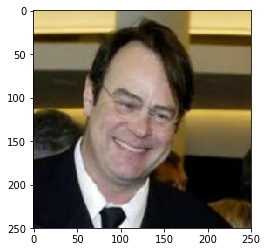

but you look like a Italian greyhound


well well, a human!


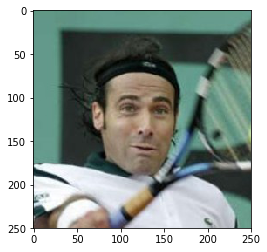

but you look like a Belgian malinois


well well, a human!


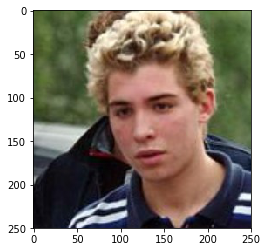

but you look like a Chinese shar-pei


well well, a dog!


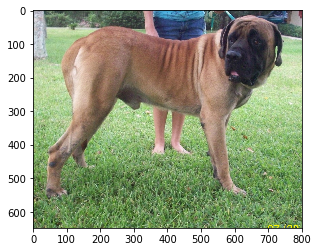

specifically a Bullmastiff


well well, a dog!


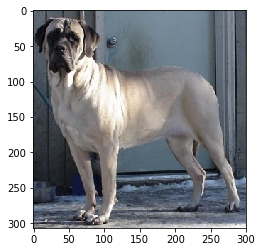

specifically a Borzoi


well well, a dog!


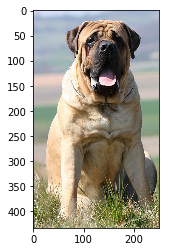

specifically a German shepherd dog




In [30]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

In [31]:
my_files = np.array(glob("/home/workspace/dog_project/my_desktop_images/*"))

well well, a dog!


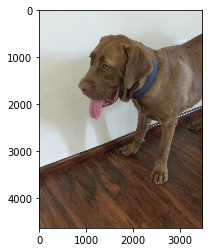

specifically a Cavalier king charles spaniel


well well, a human!


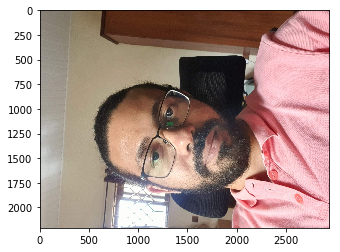

but you look like a Belgian malinois


what are you?


well well, a dog!


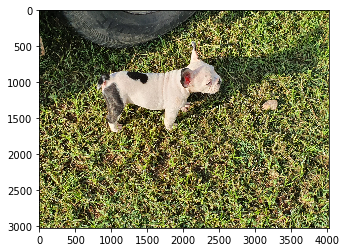

specifically a Greyhound


what are you?


well well, a dog!


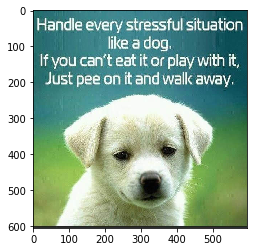

specifically a Canaan dog


well well, a human!


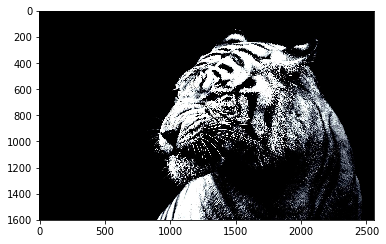

but you look like a Dalmatian


well well, a dog!


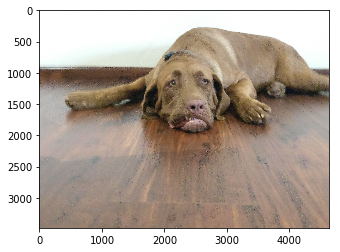

specifically a Pekingese




In [32]:
for file in np.hstack((my_files)):
    run_app(file)

well well, a dog!


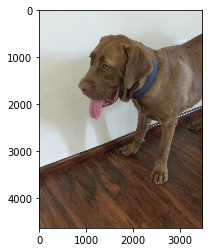

specifically a Chesapeake bay retriever


well well, a human!


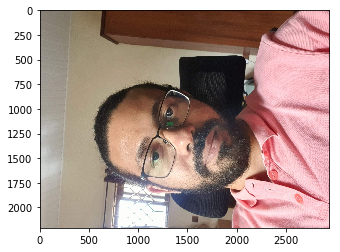

but you look like a French bulldog


what are you?




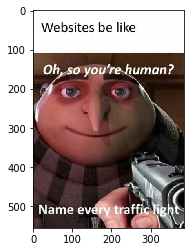

well well, a dog!


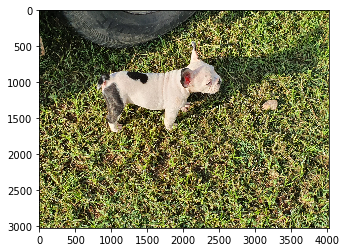

specifically a Bull terrier


what are you?




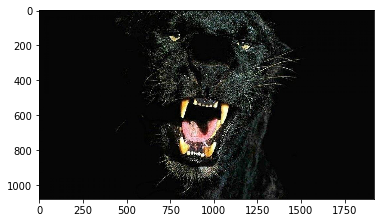

well well, a dog!


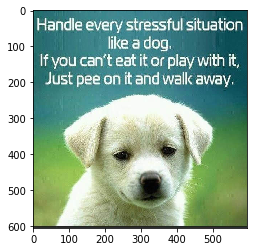

specifically a Kuvasz


well well, a human!


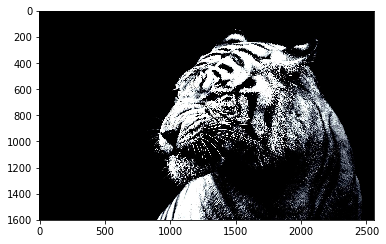

but you look like a Bulldog


well well, a dog!


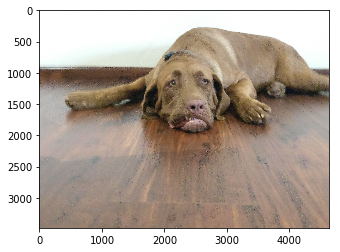

specifically a Mastiff




In [33]:
for file in np.hstack((my_files)):
    run_app_transfer(file)